In [67]:
import pandas as pd
from gmplot import gmplot
import matplotlib.pyplot as plt
from sklearn.linear_model import RANSACRegressor, LinearRegression
import numpy as np
from IPython.display import IFrame


## Configuration Parameters

In [71]:
WARMUP_DELAY = 10
MAPS_API_KEY = 'YOUR_API_KEY'
SURVEY_DATA_PATH = 'example_data.csv'

UNITREE_SITTING_STATE = 7


## Read the Data and Plot 

In [72]:
data = pd.read_csv(SURVEY_DATA_PATH, header=None, names=['timestamp', 'mode', 'latitude', 'longitude', 'elevation', 'co2_concentration'])

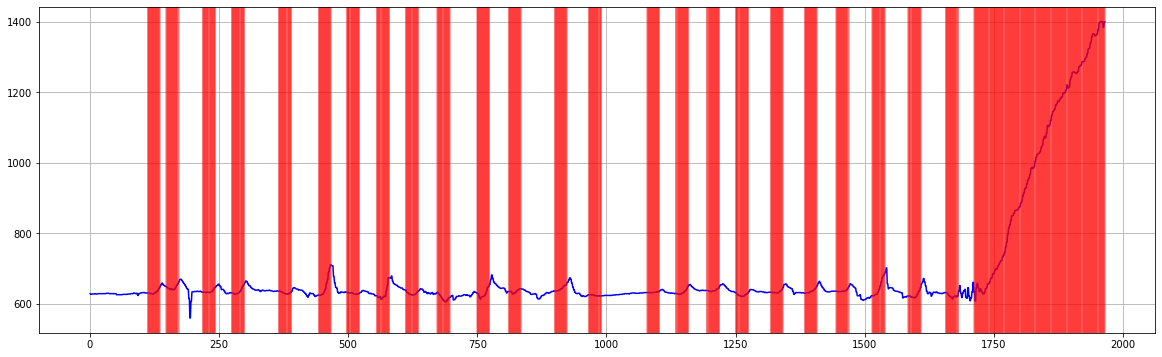

In [73]:
plt.figure(figsize=(20, 6))
plt.plot(data['timestamp'], data['co2_concentration'], linestyle='-', color='b')
highlight_indices = data[data['mode'] == UNITREE_SITTING_STATE]['timestamp']

for df_index in highlight_indices:
    plt.axvline(df_index, color='red', alpha=0.4)
    
plt.grid(True)
plt.show()


## Extract Sampling Portions and Calculate Slope

In [74]:
mask = data['mode'] == UNITREE_SITTING_STATE
groups = mask.astype(int).diff().fillna(0).ne(0).cumsum()
samples = [group for key, group in data[mask].groupby(groups) if not group.empty]

latitudes = []
longitudes = []
slopes = []
for sample in samples:
    # First portion of data is trimmed (delay in response of sampling system)
    ts = np.array(sample['timestamp'])[WARMUP_DELAY:]
    co2 = np.array(sample['co2_concentration'])[WARMUP_DELAY:]
    ts -= ts[0]
    ts = ts.reshape(-1, 1)

    # RANSAC regressor is used to reject outlier measurements
    ransac = RANSACRegressor().fit(ts, co2)
    slope = ransac.estimator_.coef_[0]

    # Location is mean GPS position during sample
    avg_lat = np.mean(sample['latitude'])
    avg_lon = np.mean(sample['longitude'])
    
    latitudes.append(avg_lat)
    longitudes.append(avg_lon)
    slopes.append(slope)

  

## Plot on Map

In [66]:
# Initialize the map
gmap = gmplot.GoogleMapPlotter(np.mean(latitudes), np.mean(longitudes), 20, apikey=MAPS_API_KEY)

# Create heatmap
gmap.heatmap(latitudes, longitudes, weights=slopes, radius=100, max_intensity=np.max(slopes))

# Save the map to an HTML file
output_file = 'heatmap.html'
gmap.draw(output_file)

Heatmap has been saved to heatmap.html


In [68]:
IFrame(src="heatmap.html", width='100%', height='1000px')